/Users/sukumargv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sukumargv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sukumargv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

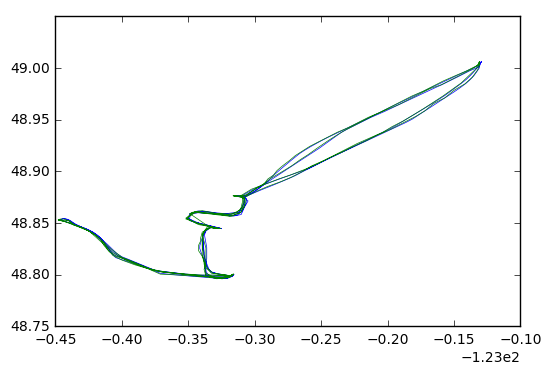

In [241]:
import numpy as np

# For loading the data into Dataframes
import pandas as pd

# For string literal 
import ast

# import packages related to gdal
from osgeo import gdal
import pyproj

# For time Zone Conversions
import pytz

with open('../data_collection/track_data/r2_Queen_of_Nanaimo.json') as f:
	for line in f:
		data = line

# Imported data now is in string format 
# Convert it into list of lists which we know the data structure of imported file.

data = ast.literal_eval(data)

# Covnert into numpy array
np.array(data)

# Assigning datatypes
mt_data = np.array([tuple(x) for x in data], dtype = [('lon', 'f8'), ('lat', 'f8'), ('speed', 'i4'), ('course', 'i4'), ('heading', 'i4'), ('timestamp', 'M8[s]'), ('ut', 'i8'), ('station', 'i8'), ('gap','i4')])

mt_data = pd.DataFrame(mt_data)
mt_data.sort_values(by='timestamp')


tz_est = pytz.timezone('UTC')

tz_pst = "US/Pacific"

# Convert timezone of the data to Pacific

mt_data['timestamp'] = mt_data['timestamp'].dt.tz_localize(tz_est).dt.tz_convert(tz_pst)

bc_data = pd.read_pickle('bc_data.pkl')

# lon_lat to cart
def lon_lat_to_cart(mt_row, index):
    inProj = pyproj.Proj(init='epsg:3857')
    outProj = pyproj.Proj(init='epsg:4326')
    cart_x, cart_y = pyproj.transform(inProj, outProj, mt_row['lat'], mt_row['lon'])
    if index ==0:
        return cart_x
    if index ==1:
        return cart_y
mt_data['cart_x'] = bc_route_data.apply(lambda x: lon_lat_to_cart(x,0), axis = 1)
mt_data['cart_y'] = bc_route_data.apply(lambda x: lon_lat_to_cart(x,1), axis = 1)


# pixels to coordinates conversion funciton can only be applied upon 

def pixels_to_coordinates(bc_row,route_tif,index):
    # load in the route image
    ds = gdal.Open(route_tif)

    # unravel GDAL affine transform parameters
    c, a, b, f, d, e = ds.GetGeoTransform()
    def pixel2coord(col, row):
        # Returns global coordinates to pixel center using base-0 raster index
        xp = a * col + b * row + a * (-5.5) + b * (-5.5) + c
        yp = d * col + e * row + d * (-5.5) + e * (-5.5) + f
        return xp, yp

    cart_cord = pixel2coord(bc_row['cx'],bc_row['cy'])

    # Converting coordinates from EPSG 3857 to 4326
    inProj = pyproj.Proj(init='epsg:3857')
    outProj = pyproj.Proj(init='epsg:4326')

    coordinates = pyproj.transform(inProj, outProj, cart_cord[0], cart_cord[1])
    local_dict = {'lat': coordinates[1], 'lon': coordinates[0], 'cart_cord_x': cart_cord[0], 'cart_cord_y': cart_cord[1] }
    if index==0:
        return local_dict['lat']
    if index==1:
        return local_dict['lon']
    if index==2:
        return local_dict['cart_cord_x']
    if index==3:
        return local_dict['cart_cord_y']

# Route file location
route_file = "../qgis_approach/route2.tif"

# Filter specific route based on timestamp
mt_data_min_time = mt_data['timestamp'].min()
mt_data_max_time = mt_data['timestamp'].max()

# Localize time_Zone of Bc_Data to Pacific time.

bc_data['Time'] = bc_data['Time'].dt.tz_localize(tz_pst)

# Need to modify it so that can be supplied from input
vessel_name = 'Queen of Nanaimo'
bc_route_data = bc_data[(bc_data['Time'] >= mt_data_min_time) & (bc_data['Time'] <= mt_data_max_time) & (bc_data['Vessel'] == vessel_name)]

bc_route_data['lon'] = bc_route_data.apply(lambda x: pixels_to_coordinates(x,route_file,0), axis = 1)
bc_route_data['lat'] = bc_route_data.apply(lambda x: pixels_to_coordinates(x,route_file,1), axis = 1)
bc_route_data['cart_x'] = bc_route_data.apply(lambda x: pixels_to_coordinates(x,route_file,2), axis = 1)
bc_route_data['cart_y'] = bc_route_data.apply(lambda x: pixels_to_coordinates(x,route_file,3), axis = 1)

bc_route_data['dup_key'] = bc_route_data['cx'] + bc_route_data['cy']
no_dups_bc_route_data = bc_route_data.drop_duplicates('dup_key')


# Plot of all the route data
plt.plot(mt_data['lon'], mt_data['lat'],'-',linewidth=0.5, color = 'blue')
plt.plot(bc_route_data['lat'], bc_route_data['lon'],'-',linewidth=0.5, color ='green')
plt.show()

In [ ]:
plt.plot(mt_data['lon'], mt_data['lat'],'-',linewidth=0.5, color = 'blue')
plt.plot(bc_route_data['lat'], bc_route_data['lon'],'-',linewidth=0.5, color ='green')
plt.show()

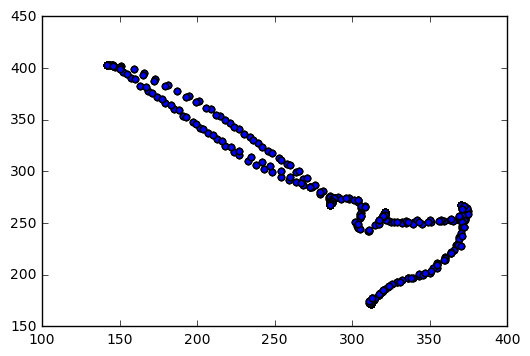

In [177]:
plt.scatter(bc_route_data['cx'], bc_route_data['cx'])
plt.show()

/Users/sukumargv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/sukumargv/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


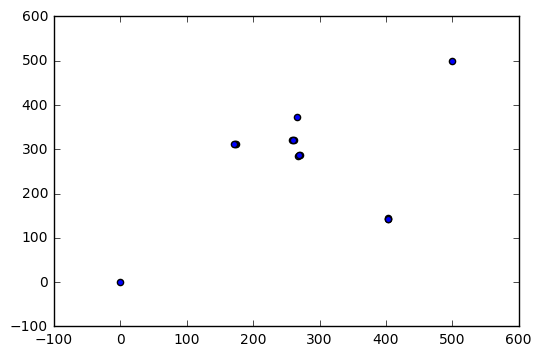

In [106]:
no_dups_bc_route_data.loc[len(no_dups_bc_route_data)] = ['Southern Gulf Islands','SW','9:16 PM','In Port','2016-11-16 21:20:32-08:00','Canada/Pacific', 'Queen of Nanaimo', 'r02', '0.0','0','0','247','261','312','326','48.841588','-123.327816','573']
no_dups_bc_route_data.loc[len(no_dups_bc_route_data)] = ['Southern Gulf Islands','SW','9:16 PM','In Port','2016-11-16 21:20:32-08:00','Canada/Pacific', 'Queen of Nanaimo', 'r02', '0.0','500','500','247','261','312','326','48.841588','-123.327816','573']

# Plot cx, cy as scatterplot 
import matplotlib.pyplot as plt
plt.scatter(no_dups_bc_route_data[(no_dups_bc_route_data['Status']== 'In Port')]['cx'], no_dups_bc_route_data[(no_dups_bc_route_data['Status']== 'In Port')]['cy'])
plt.show()

In [195]:
no_dups_bc_route_data[(no_dups_bc_route_data['Status']== 'In Port')]['Time']

34648   2016-11-16 17:40:33-08:00
34656   2016-11-16 17:44:32-08:00
34752   2016-11-16 18:32:31-08:00
34756   2016-11-16 18:34:32-08:00
34760   2016-11-16 18:36:31-08:00
35052   2016-11-16 21:02:31-08:00
35056   2016-11-16 21:04:31-08:00
35152   2016-11-16 21:52:31-08:00
35224   2016-11-16 22:28:32-08:00
35228   2016-11-16 22:30:31-08:00
35232   2016-11-16 22:32:31-08:00
35992   2016-11-17 08:16:33-08:00
36986   2016-11-17 16:36:31-08:00
Name: Time, dtype: datetime64[ns, US/Pacific]

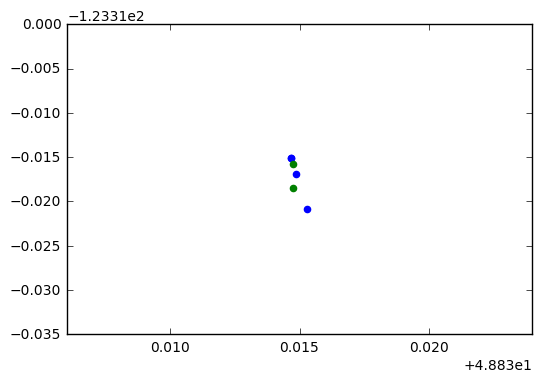

In [225]:
filter_1 = mt_data[['lat', 'lon','timestamp']][(mt_data['timestamp']>= '2016-11-16 21:00:31-08:00')& (mt_data['timestamp']<= '2016-11-16 21:15:31-08:00')]
filter_1_ = no_dups_bc_route_data[['lon', 'lat','Time']][(no_dups_bc_route_data['Time']>= '2016-11-16 21:00:31-08:00')& (no_dups_bc_route_data['Time']<= '2016-11-16 21:15:31-08:00')]
plt.scatter(filter_1['lat'], filter_1['lon'], color ='blue')
plt.scatter(filter_1_['lon'],filter_1_['lat'], color = 'green')
filter_1
filter_1_
plt.show()

In [243]:
bc_route_data

,Destination,Heading,Last Update,Status,Time,Timezone,Vessel,route_no,speed,cx,cy,x1,x2,y1,y2,lon,lat,cart_x,cart_y,dup_key
34648,Tsawwassen,NW,5:36 PM,In Port,2016-11-16 17:40:33-08:00,Canada/Pacific,Queen of Nanaimo,r02,0.0,268,286,261,275,279,293,48.876359,-123.316148,-1.372749e+07,6.253908e+06,554
34649,Tsawwassen,NW,5:36 PM,In Port,2016-11-16 17:41:01-08:00,Canada/Pacific,Queen of Nanaimo,r02,0.0,268,286,261,275,279,293,48.876359,-123.316148,-1.372749e+07,6.253908e+06,554
34650,Tsawwassen,NW,5:36 PM,In Port,2016-11-16 17:41:31-08:00,Canada/Pacific,Queen of Nanaimo,r02,0.0,268,286,261,275,279,293,48.876359,-123.316148,-1.372749e+07,6.253908e+06,554
34651,Tsawwassen,NW,5:36 PM,In Port,2016-11-16 17:42:00-08:00,Canada/Pacific,Queen of Nanaimo,r02,0.0,268,286,261,275,279,293,48.876359,-123.316148,-1.372749e+07,6.253908e+06,554
34652,Tsawwassen,E,5:40 PM,Under Way,2016-11-16 17:42:31-08:00,Canada/Pacific,Queen of Nanaimo,r02,4.0,270,287,263,277,280,294,48.875456,-123.313402,-1.372719e+07,6.253755e+06,557
34653,Tsawwassen,E,5:40 PM,Under Way,2016-11-16 17:43:01-08:00,Canada/Pacific,Queen of Nanaimo,r02,4.0,270,287,263,277,280,294,48.875456,-123.313402,-1.372719e+07,6.253755e+06,557
34654,Tsawwassen,E,5:40 PM,Under Way,2016-11-16 17:43:31-08:00,Canada/Pacific,Queen of Nanaimo,r02,4.0,270,287,263,277,280,294,48.875456,-123.313402,-1.372719e+07,6.253755e+06,557
34655,Tsawwassen,E,5:40 PM,Under Way,2016-11-16 17:44:01-08:00,Canada/Pacific,Queen of Nanaimo,r02,4.0,270,287,263,277,280,294,48.875456,-123.313402,-1.372719e+07,6.253755e+06,557
34656,Tsawwassen,N,5:42 PM,In Port,2016-11-16 17:44:32-08:00,Canada/Pacific,Queen of Nanaimo,r02,0.0,271,287,264,278,280,294,48.875456,-123.312030,-1.372703e+07,6.253755e+06,558
34657,Tsawwassen,N,5:42 PM,In Port,2016-11-16 17:45:02-08:00,Canada/Pacific,Queen of Nanaimo,r02,0.0,271,287,264,278,280,294,48.875456,-123.312030,-1.372703e+07,6.253755e+06,558


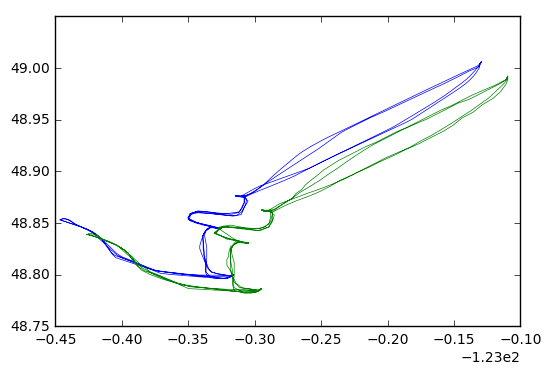

In [190]:
# Plot of all the route data
plt.plot(mt_data['lon'], mt_data['lat'],'-',linewidth=0.5, color = 'blue')
plt.plot(bc_route_data['lat'], bc_route_data['lon'],'-',linewidth=0.5, color ='green')
plt.show()

In [180]:
import charts
charts.plot(bc_route_data)

Opening new tab...
